In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import files
#files.upload()

In [9]:
bdf = pd.read_csv('SeoulBikeData.csv', encoding = 'unicode_escape')
bdf.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [ ]:

bdf.columns
bdf['Hour avg'] = bdf.groupby(['Hour'])['Rented Bike Count'].transform('mean')
bdf['Season avg'] = bdf.groupby(['Seasons'])['Rented Bike Count'].transform('mean')
#bdf['']
#plot = sns.barplot(data = bdf, x = 'Seasons', y = 'Season avg')
#plot = sns.boxplot(data = bdf, x = 'Holiday', y = 'Rented Bike Count')
#plot = sns.boxplot(data = bdf, x = 'Seasons', y = 'Rented Bike Count')
#plot = sns.lineplot(data = bdf, x = 'Hour', y = 'Rented Bike Count')
#plot = sns.lineplot(data = bdf, x= 'Temperature(°C)', y = 'Rented Bike Count')
#plot = sns.scatterplot(data = bdf, x= 'Rainfall(mm)', y = 'Rented Bike Count')

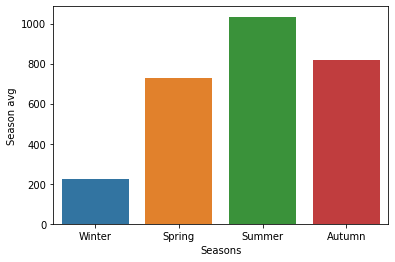

In [19]:
plot = sns.barplot(data = bdf, x = 'Seasons', y = 'Season avg')

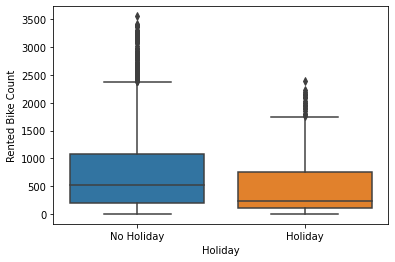

In [14]:
plot = sns.boxplot(data = bdf, x = 'Holiday', y = 'Rented Bike Count')

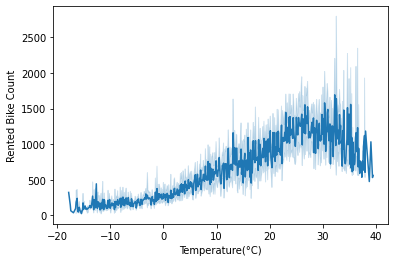

In [15]:
plot = sns.lineplot(data = bdf, x= 'Temperature(°C)', y = 'Rented Bike Count')

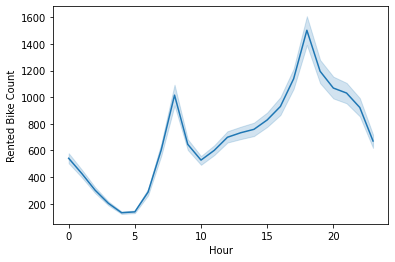

In [16]:
plot = sns.lineplot(data = bdf, x = 'Hour', y = 'Rented Bike Count')